In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-6b-100d/glove.6B.100d.txt


In [2]:
#Importing libraries
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
import gc
import random
from nltk.corpus import stopwords
import re
import string
from datasets import Dataset
import glob
from tqdm import tqdm
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import f1_score
import lightgbm as lgb
import optuna


import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
from transformers import TrainingArguments, default_data_collator, Trainer

In [3]:
#Loading data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [8]:
len(train)

7613

In [9]:
train['id'].nunique()

7613

In [10]:
train['keyword'].nunique()

221

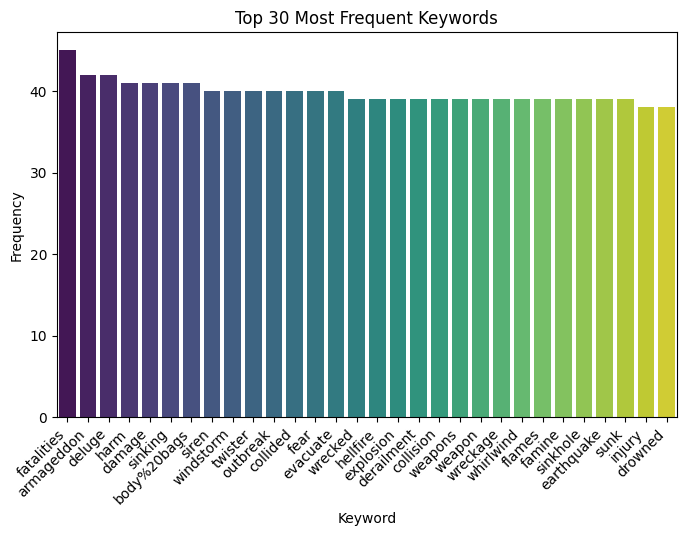

In [11]:
#Keyword frequency visualization
keyword_counts = train['keyword'].value_counts()

top_keywords = keyword_counts.head(30)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Most Frequent Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')

plt.show()

In [12]:
train['location'].nunique()

3341

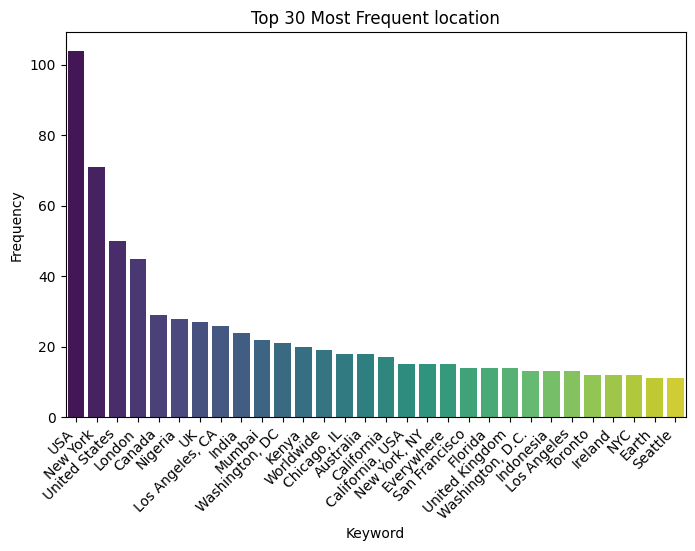

In [13]:
#Location Frequency Visualization
keyword_counts = train['location'].value_counts()

top_keywords = keyword_counts.head(30)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_keywords.index, y=top_keywords.values, palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.title('Top 30 Most Frequent location')
plt.xlabel('Keyword')
plt.ylabel('Frequency')

plt.show()

In [14]:
#Percentage of nulls
location_non_null_ratio = train['location'].notnull().sum()/len(train)
keyword_non_null_ratio = train['keyword'].notnull().sum()/len(train)

print(f"Non-null ratio for 'location': {location_non_null_ratio:.2f}")
print(f"Non-null ratio for 'keyword': {keyword_non_null_ratio:.2f}")

Non-null ratio for 'location': 0.67
Non-null ratio for 'keyword': 0.99


In [15]:
#The percentage of null values is high, and location and keyword may not be used as null values.

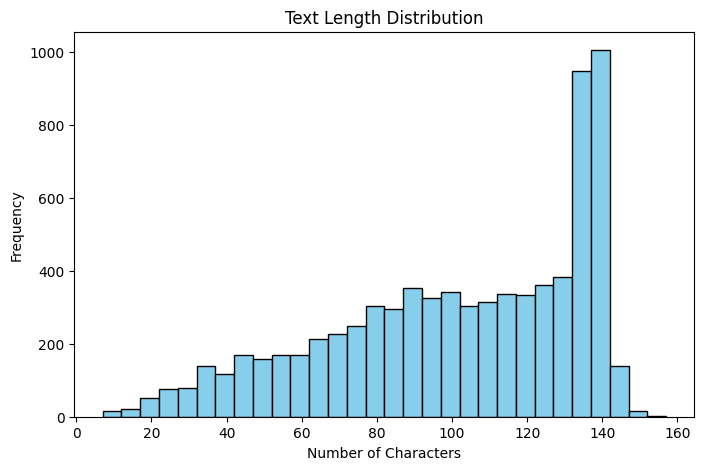

In [16]:
#Character length histogram
train['text_length'] = train['text'].str.len()

plt.figure(figsize=(8, 5))
plt.hist(train['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [17]:
#We could also create a 'count' column to add the number of characters as a feature.

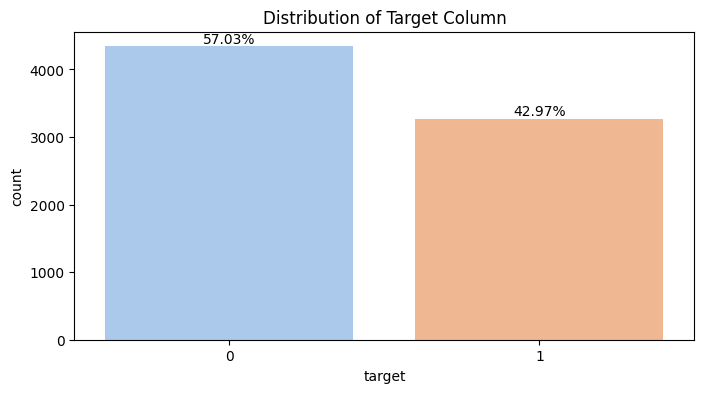

In [18]:
#Visualization of proportions of the objective variable
plt.figure(figsize=(8,4))
ax=sns.countplot(x='target',data=train,palette='pastel')
plt.title('Distribution of Target Column')

total = len(train['target'])
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')
    
plt.show()

In [19]:
train.drop(columns='id',inplace=True)

In [20]:
#Data Cleansing function

stopwords = stopwords.words('english')

def cleansing(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"http\S+", "",text) #Removing URLs     
    html=re.compile(r'<.*?>') 
    text = html.sub(r'',text) #Removing html tags
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations    
    text = [word.lower() for word in text.split() if word.lower() not in stopwords]
    text = " ".join(text) #removing stopwords
    
    return text

In [21]:
train['text'] = train['text'].apply(lambda x: cleansing(x))

In [22]:
tf_idf = TfidfVectorizer()

In [23]:
X = tf_idf.fit_transform(train['text'])
y = train['target']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)

In [25]:
#Compare models
#At first, random forest

model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.3f}')
print("Classification Report of Random Forest:\n", classification_report(y_val, y_pred))

Accuracy: 0.794
Classification Report of Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84       886
           1       0.87      0.60      0.71       637

    accuracy                           0.79      1523
   macro avg       0.82      0.77      0.77      1523
weighted avg       0.81      0.79      0.79      1523



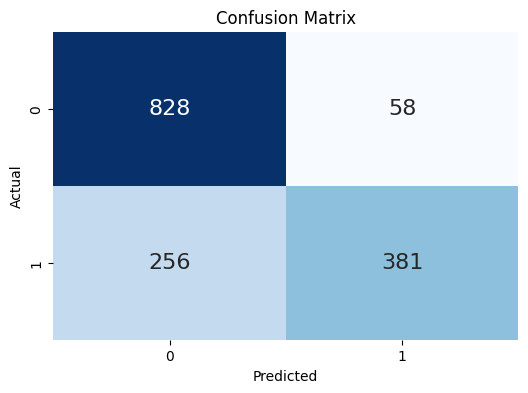

In [26]:
#Displaying random forest prediction results
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
#Displaying prediction results using lightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
}

verbose_eval = 0
model = lgb.train(params, train_data, valid_sets=[test_data], 
                  num_boost_round=1000,
                  callbacks=[lgb.early_stopping(stopping_rounds=10, 
                            verbose=True),
                           lgb.log_evaluation(verbose_eval)])

y_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

[LightGBM] [Info] Number of positive: 2634, number of negative: 3456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8551
[LightGBM] [Info] Number of data points in the train set: 6090, number of used features: 591
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432512 -> initscore=-0.271608
[LightGBM] [Info] Start training from score -0.271608
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_error: 0.214708
Accuracy: 0.7853


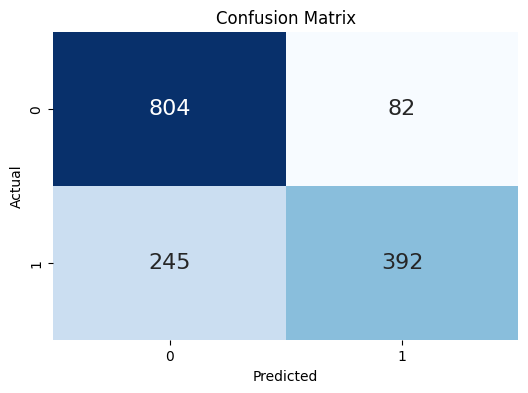

In [28]:
#Displaying prediction results using lightGBM
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred_binary), annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
#Since the amount of data is relatively small, I will attempt crossvalidation.

In [30]:
#from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'objective': 'binary',        
    'metric': 'binary_error', 
    'boosting_type': 'gbdt', 
}

f1_list = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model_cv = lgb.train(params, train_data, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=100, 
                            verbose=True),
                           lgb.log_evaluation(verbose_eval)])
    
    y_pred_prob = model_cv.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_list.append(f1)

print(f'average score: {np.mean(f1_list)}')

[LightGBM] [Info] Number of positive: 2622, number of negative: 3468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8549
[LightGBM] [Info] Number of data points in the train set: 6090, number of used features: 591
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430542 -> initscore=-0.279641
[LightGBM] [Info] Start training from score -0.279641
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_error: 0.22981
[LightGBM] [Info] Number of positive: 2622, number of negative: 3468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

In [31]:
#I used Optuna to tune the hyperparameters, but F1 did not improve.

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
bert_sc = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
bert_sc = bert_sc.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
train.rename(columns={'target': 'labels'}, inplace=True)

In [35]:
from datasets import Dataset
dataset = Dataset.from_pandas(train)

In [36]:
#arrange the data format
max_length =128
dataset_for_loader =[]
for sample in dataset:
    text = sample["text"]
    labels = sample["labels"]
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding = "max_length",
        truncation =True
    )
    encoding["labels"] =labels
    encoding = {k:torch.tensor(v) for k, v in encoding.items()}
    dataset_for_loader.append(encoding)
 
#split the dataset
random.shuffle(dataset_for_loader)
n = len(dataset_for_loader)
n_train = int(n*0.6)
n_val = int(n*0.2)
dataset_train = dataset_for_loader[:n_train]
dataset_val = dataset_for_loader[n_train:n_train+n_val]
dataset_test = dataset_for_loader[n_train+n_val:]

#create dataloader from dataset
dataloader_train = DataLoader(
    dataset_train,batch_size=32,shuffle=True
)
dataloader_val = DataLoader(dataset_val, batch_size=256)
dataloader_test = DataLoader(dataset_test, batch_size=256)

In [37]:
#Creating a fine-tuning class
class BertForSequenceClassification_pl(pl.LightningModule):

    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters()

        self.bert_sc = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
            )
    
    def training_step(self,batch,batch_idx):
        output = self.bert_sc(**batch)
        loss = output.loss
        self.log('train_loss',loss)
        return loss
    
    def validation_step(self,batch,batch_idx):
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log('val_loss',val_loss)
        return val_loss
    
    def test_step(self,batch,batch_idx):
        labels = batch.pop('labels')
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        num_correct = (labels_predicted==labels).sum().item()
        accuracy = num_correct/labels.size(0)
        self.log('accuracy',accuracy)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=self.hparams.lr)
    

In [38]:
#Set conditions for saving model weights during training
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor ="val_loss",
    mode ="min",
    save_top_k = 1,
    save_weights_only = True,
    dirpath ="model/",
)

In [39]:
##Setting the train method
trainer = pl.Trainer(
    #gpus =1 ,
    max_epochs =5,
    callbacks = [checkpoint]
)

In [40]:
#Load Model
model = BertForSequenceClassification_pl(
    'bert-base-uncased',
    num_labels =2,
    lr = 1e-5
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
#Fine-tuning
trainer.fit(model,dataloader_train,dataloader_val)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [42]:
best_model_path = checkpoint.best_model_path
print("best_model",checkpoint.best_model_path)
print("best_model_loss",checkpoint.best_model_score)

best_model /kaggle/working/model/epoch=0-step=143.ckpt
best_model_loss tensor(0.4225, device='cuda:0')


In [43]:
testing = trainer.test(model, dataloaders= dataloader_test)
testing[0]["accuracy"]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.817585289478302     │
└───────────────────────────┴───────────────────────────┘

0.817585289478302

In [44]:
model = BertForSequenceClassification_pl.load_from_checkpoint(best_model_path)
model.bert_sc.save_pretrained("/kaggle/working/")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
